## 셋업

In [ ]:
# sudo apt install -y fluidsynth

In [ ]:
# pip install --upgrade pyfluidsynth

In [ ]:
# pip install pretty_midi

In [1]:
import collections
import datetime
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from IPython import display
from matplotlib import pyplot as plt
from typing import Dict, List, Optional, Sequence, Tuple
import os

2024-04-15 02:54:52.924000: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-15 02:54:52.949628: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 02:54:52.949666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 02:54:52.950839: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 02:54:52.956137: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import fluidsynth

In [3]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

## 시작

In [4]:
#import all the file names
filenames = glob.glob(str("MIDI/pop/**/*.mid"))
filenames_country = glob.glob(str("MIDI/country/**/*.mid"))
filenames_blues = glob.glob(str("MIDI/blues/**/*.mid"))
filenames_hiphop = glob.glob(str("MIDI/hip-hop-rap/**/*.mid"))
# filenames = glob.glob(str("/home/jayden/projects/project_lyrics/MIDI/pop/**/*.mid"))
print('Number of files: ', len(filenames))
sample_file = filenames[4]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)

Number of files:  2898
MIDI/pop/Yazoo/Smile.mid


In [5]:
#악기 종류 찾아내기
print('Number of instruments:', len(pm.instruments))
instrument = pm.instruments[0]
instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
print('Instrument name:', instrument_name)

for num in range(len(pm.instruments)):
    print('All instruments:' , pretty_midi.program_to_instrument_name(pm.instruments[num].program))

Number of instruments: 8
Instrument name: Acoustic Grand Piano
All instruments: Acoustic Grand Piano
All instruments: Acoustic Grand Piano
All instruments: Bright Acoustic Piano
All instruments: Synth Bass 2
All instruments: Distortion Guitar
All instruments: Fretless Bass
All instruments: Lead 2 (sawtooth)
All instruments: Voice Oohs


In [6]:
#오디오를 30초간 들을수 있는 펑션
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [7]:
sample_file = filenames[4]
print(sample_file)
pm = pretty_midi.PrettyMIDI(sample_file)
print(pm.instruments[0])

display_audio(pm)

MIDI/pop/Yazoo/Smile.mid
Instrument(program=0, is_drum=True, name="Drums")


In [8]:
# 한가지의 악기가 메인으로 사용되는지 확인.
def get_percent_monophonic(pm_instrument_roll):
    mask = pm_instrument_roll.T > 0
    notes = np.sum(mask, axis=1)
    n = np.count_nonzero(notes)
    single = np.count_nonzero(notes == 1)
    if single > 0:
        return float(single) / float(n)
    elif single == 0 and n > 0:
        return 0.0
    else: # no notes of any kind
        return 0.0
    
def filter_monophonic(pm_instruments, percent_monophonic=0.9):
    return [i for i in pm_instruments if \
            get_percent_monophonic(i.get_piano_roll()) >= percent_monophonic]

In [9]:
# returns 2 dataframes and 1 dictionary, one consisting of all file, another consisting of monophonic notes data.
def count_instruments(file_list):
    instrument_counts = {}  # Dictionary to store instrument counts for each file
    melody_counts = {}
    notes_by_instrument = {}  # Dictionary to store notes for each instrument
    files_to_delete = []
    
    for file_name in file_list:
        try:
            pm = pretty_midi.PrettyMIDI(file_name)
            file_instrument_counts = {}  # Dictionary to store instrument counts for the current file
            file_melody_counts = {}
            melody_instru = filter_monophonic(pm.instruments, 1)

            for instrument in pm.instruments:
                instrument_name = pretty_midi.program_to_instrument_name(instrument.program)
                # file_instrument_counts[instrument_name] = file_instrument_counts.get(instrument_name, 0) + 1
                file_instrument_counts[instrument_name] = 1
            
            for instrument_m in melody_instru:
                instrument_name = pretty_midi.program_to_instrument_name(instrument_m.program)
                file_melody_counts[instrument_name] = 1
                notes_by_instrument[instrument_name] = notes_by_instrument.get(instrument_name, []) + [note for note in instrument_m.notes]


            # Store instrument counts for the current file in the main dictionary
            instrument_counts[file_name] = file_instrument_counts
            melody_counts[file_name] = file_melody_counts

        except Exception as e:
            print(f"Error processing file {file_name}: {e}")
            # Add the file to the list of files to delete
            files_to_delete.append(file_name)
        
    # Delete the files with errors
    for file_to_delete in files_to_delete:
        os.remove(file_to_delete)

    # Convert the dictionary to a DataFrame
    instru_df = pd.DataFrame.from_dict(instrument_counts, orient='index')
    melody_df = pd.DataFrame.from_dict(melody_counts, orient='index')

    # Fill missing values with zeros
    instru_df.fillna(0, inplace=True)
    melody_df.fillna(0, inplace=True)
    
    return instru_df, melody_df, notes_by_instrument

instrument_counts_df, melody_counts_df, melody_notes_dict = count_instruments(filenames)


/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [10]:
# training model requires 3 variables (pitch, step, duration)
# pitch : perceptual quality of the sound as a midi note
# step : time elapsed from previous note or start of the track
# duration : duration of the current note
# 미디 파일에서 음표 추출하는 부분.

# return pd.DataFrame
def midi_to_notes(midi_file: str, instrument_name: str):
  try:
    pm = pretty_midi.PrettyMIDI(midi_file)
    pm.remove_invalid_notes()
    
    # check if the specific instrument exist in the MIDI file
    instrument = None
    for inst in pm.instruments:
      if pretty_midi.program_to_instrument_name(inst.program) == instrument_name:
          instrument = inst
          break
    if instrument is None:
      raise ValueError(f"Instrument '{instrument_name}' not found in the MIDI file")

    notes = collections.defaultdict(list)

    # Sort the notes by start time
    sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
    prev_start = sorted_notes[0].start

    for note in sorted_notes:
      start = note.start
      end = note.end
      notes['pitch'].append(note.pitch)
      notes['start'].append(start)
      notes['end'].append(end)
      notes['step'].append(start - prev_start)
      notes['duration'].append(end - start)
      prev_start = start
    return pd.DataFrame({name: np.array(value) for name, value in notes.items()})
  except Exception as e:
    print(f"Error occurred while processing file {midi_file}: {e}")


In [11]:
# Save notes for each instrument in melody_instru
all_melody_notes_by_instrument = {}
for instrument_name in melody_notes_dict.keys():
    all_notes_list = []
    temp = melody_counts_df.index[melody_counts_df[instrument_name] == 1].to_list()
    for f in temp:
        notes = midi_to_notes(f, instrument_name) 
        if notes is not None:
            all_notes_list.append(notes)
    all_melody_notes_by_instrument[instrument_name] = all_notes_list

# Concatenate DataFrames separately for each instrument
melody_notes_by_instrument_df = {}
for instrument_name, notes_list in all_melody_notes_by_instrument.items():
    melody_notes_by_instrument_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


In [12]:
# access notes for each instrument:
for instrument_name, notes_df in melody_notes_by_instrument_df.items():
    print(f"Notes for instrument '{instrument_name}':")
    print(notes_df)

Notes for instrument 'Reverse Cymbal':
      pitch       start         end      step  duration
0        60   39.000000   40.000000   0.00000  1.000000
1        60  107.000000  107.973958  68.00000  0.973958
2        60  155.000000  156.000000  48.00000  1.000000
3        60  191.000000  192.000000  36.00000  1.000000
4        60  259.000000  260.000000  68.00000  1.000000
...     ...         ...         ...       ...       ...
1265     56  192.800000  193.730000  12.80000  0.930000
1266     56  205.600000  206.530000  12.80000  0.930000
1267     56  218.400000  219.330000  12.80000  0.930000
1268     60   18.488361   19.883709   0.00000  1.395348
1269     60   28.953471   30.523237  10.46511  1.569767

[1270 rows x 5 columns]
Notes for instrument 'Voice Oohs':
      pitch       start         end      step  duration
0        62  104.307393  104.412898  0.000000  0.105505
1        62  104.445008  104.564274  0.137615  0.119266
2        62  104.582623  104.706476  0.137615  0.123853
3    

In [13]:
instrument_counts_df.head()

Tango Accordion  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid              1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid               1.0   
MIDI/pop/Gary Wright/AprilinParis.mid               1.0   
MIDI/pop/Sam Smith/GardenParty.mid                  1.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                   1.0   

                                        Electric Bass (finger)  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                     1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid                      0.0   
MIDI/pop/Gary Wright/AprilinParis.mid                      0.0   
MIDI/pop/Sam Smith/GardenParty.mid                         0.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                          0.0   

                                        Electric Guitar (jazz)  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                     1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid                      0.0   
MIDI/pop/Gary Wright/AprilinParis.mid                      0.0   
MIDI/pop/Sam Smith/GardenParty.mid                         1.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                          0.0   

                                        Acoustic Guitar (steel)  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                      1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid                       1.0   
MIDI/pop/Gary Wright/AprilinParis.mid                       0.0   
MIDI/pop/Sam Smith/GardenParty.mid                          1.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                           0.0   

                                        Bright Acoustic Piano  Synth Choir  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                    1.0          1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid                     0.0          0.0   
MIDI/pop/Gary Wright/AprilinParis.mid                     0.0          0.0   
MIDI/pop/Sam Smith/GardenParty.mid                        0.0          0.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                         0.0          0.0   

                                        String Ensemble 1  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid                 0.0   
MIDI/pop/Gary Wright/AprilinParis.mid                 0.0   
MIDI/pop/Sam Smith/GardenParty.mid                    0.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                     1.0   

                                        Acoustic Grand Piano  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                   1.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid                    1.0   
MIDI/pop/Gary Wright/AprilinParis.mid                    0.0   
MIDI/pop/Sam Smith/GardenParty.mid                       1.0   
MIDI/pop/BBMak/CouldItBeMagic.mid                        1.0   

                                        Electric Grand Piano  Shakuhachi  ...  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid                   0.0         0.0  ...   
MIDI/pop/Jann Arden/GoldDustWoman.mid                    0.0         0.0  ...   
MIDI/pop/Gary Wright/AprilinParis.mid                    0.0         0.0  ...   
MIDI/pop/Sam Smith/GardenParty.mid                       0.0         0.0  ...   
MIDI/pop/BBMak/CouldItBeMagic.mid                        0.0         0.0  ...   

                                        Slap Bass 2  FX 6 (goblins)  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid          0.0             0.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid           0.0             0.0   
MIDI/pop/Gary Wright/AprilinParis.mid           0.0             0.0   
MIDI/pop/Sam Smith/GardenParty.mid              0.0             0.0   
MIDI/pop/BBMak/CouldItBeMagic.mid               0.0             0.0   

                                        Orchestra Hit  FX 3 (crystal)  \
MIDI/pop/Marcels/IdLoveYouToWantMe.mid            0.0             0.0   
MIDI/pop/Jann Arden/GoldDustWoman.mid             0.0             0.0   
MIDI/pop/Gary Wright/AprilinParis.mid             0.0             0.0   
MIDI/pop/Sam Smith/GardenParty.mid                0.0        

In [14]:
melody_counts_df.head()

Reverse Cymbal  Voice Oohs  \
MIDI/pop/Yazoo/Graduation(2).mid                           1.0         0.0   
MIDI/pop/Romantics/GangnamStyle.mid                        1.0         0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid             1.0         0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                         1.0         0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid              1.0         1.0   

                                                Distortion Guitar  Gunshot  \
MIDI/pop/Yazoo/Graduation(2).mid                              0.0      0.0   
MIDI/pop/Romantics/GangnamStyle.mid                           1.0      0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid                1.0      0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                            0.0      0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid                 0.0      0.0   

                                                Electric Guitar (clean)  Oboe  \
MIDI/pop/Yazoo/Graduation(2).mid                                    0.0   0.0   
MIDI/pop/Romantics/GangnamStyle.mid                                 0.0   0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid                      0.0   0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                                  0.0   0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid                       0.0   1.0   

                                                Alto Sax  \
MIDI/pop/Yazoo/Graduation(2).mid                     0.0   
MIDI/pop/Romantics/GangnamStyle.mid                  0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid       0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                   0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid        0.0   

                                                Electric Bass (finger)  \
MIDI/pop/Yazoo/Graduation(2).mid                                   0.0   
MIDI/pop/Romantics/GangnamStyle.mid                                0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid                     0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                                 0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid                      0.0   

                                                Clarinet  Acoustic Bass  ...  \
MIDI/pop/Yazoo/Graduation(2).mid                     0.0            0.0  ...   
MIDI/pop/Romantics/GangnamStyle.mid                  0.0            0.0  ...   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid       0.0            0.0  ...   
MIDI/pop/Roxette/BeginTheBegin.mid                   0.0            0.0  ...   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid        0.0            0.0  ...   

                                                Melodic Tom  FX 6 (goblins)  \
MIDI/pop/Yazoo/Graduation(2).mid                        0.0             0.0   
MIDI/pop/Romantics/GangnamStyle.mid                     0.0             0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid          0.0             0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                      0.0             0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid           0.0             0.0   

                                                Brass Section  \
MIDI/pop/Yazoo/Graduation(2).mid                          0.0   
MIDI/pop/Romantics/GangnamStyle.mid                       0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid            0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                        0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid             0.0   

                                                Lead 7 (fifths)  \
MIDI/pop/Yazoo/Graduation(2).mid                            0.0   
MIDI/pop/Romantics/GangnamStyle.mid                         0.0   
MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid              0.0   
MIDI/pop/Roxette/BeginTheBegin.mid                          0.0   
MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid               0.0   

                                                Orchestra Hit  FX 8

In [15]:
melody_counts_df.index

Index(['MIDI/pop/Yazoo/Graduation(2).mid',
       'MIDI/pop/Romantics/GangnamStyle.mid',
       'MIDI/pop/Romantics/gangnamstyleKILLYURSLEF.mid',
       'MIDI/pop/Roxette/BeginTheBegin.mid',
       'MIDI/pop/Byrds/JustTheWayyouAre.withLyric.mid',
       'MIDI/pop/Byrds/JustTheWayYouAre.mid',
       'MIDI/pop/Tina Arena/BreakYourHeart.mid',
       'MIDI/pop/James Taylor/Gloryland.mid', 'MIDI/pop/Jay-Z/Human.mid',
       'MIDI/pop/Newsboys/MidnightSky.mid',
       ...
       'MIDI/pop/Evan and Jaron/RedRosesForMyLady.mid',
       'MIDI/pop/Dave Clark Five/SheBop.mid',
       'MIDI/pop/Robbie Williams/AgainstAllOds.mid',
       'MIDI/pop/Chris Brown/TheBeatGoesOn.mid',
       'MIDI/pop/Enrique Iglesias/Don’tLettheSunGoDownonMe.mid',
       'MIDI/pop/Cyndi Lauper/Irresistable.mid',
       'MIDI/pop/Bangles/GetDown.mid', 'MIDI/pop/Chess/Jattendias.mid',
       'MIDI/pop/Chess/ItsAllComingBackToMeNow.mid',
       'MIDI/pop/The Wanted/Inside.mid'],
      dtype='object', length=2031)

In [16]:
top_instru = instrument_counts_df.sum().nlargest(20)
print(top_instru.index[0])
m_top_instru = melody_counts_df.sum().nlargest(20)
print(m_top_instru)

Acoustic Grand Piano
Electric Bass (finger)     431.0
Acoustic Grand Piano       237.0
Reverse Cymbal             226.0
Fretless Bass              163.0
Electric Guitar (muted)    140.0
Acoustic Bass              131.0
String Ensemble 1          128.0
Electric Bass (pick)       122.0
Flute                      110.0
Lead 2 (sawtooth)          100.0
Synth Bass 1                94.0
Synth Bass 2                91.0
Distortion Guitar           83.0
Alto Sax                    81.0
Choir Aahs                  79.0
Overdriven Guitar           75.0
Electric Guitar (clean)     69.0
Voice Oohs                  67.0
Tenor Sax                   64.0
Pan Flute                   63.0
dtype: float64


In [17]:
instrument_counts_df.sum().index

Index(['Tango Accordion', 'Electric Bass (finger)', 'Electric Guitar (jazz)',
       'Acoustic Guitar (steel)', 'Bright Acoustic Piano', 'Synth Choir',
       'String Ensemble 1', 'Acoustic Grand Piano', 'Electric Grand Piano',
       'Shakuhachi',
       ...
       'Slap Bass 2', 'FX 6 (goblins)', 'Orchestra Hit', 'FX 3 (crystal)',
       'Marimba', 'Dulcimer', 'Tinkle Bell', 'Lead 7 (fifths)', 'Koto',
       'Agogo'],
      dtype='object', length=128)

In [18]:
# 나중에 인덱스 찾아서 특정 악기 데이터 뽑기위해서 테스트. 
# 특정 악기 사용한 미디 파일 이름들 추출.
test = instrument_counts_df.index[instrument_counts_df[top_instru.index[0]] == 1].tolist()
print(test)

['MIDI/pop/Marcels/IdLoveYouToWantMe.mid', 'MIDI/pop/Jann Arden/GoldDustWoman.mid', 'MIDI/pop/Sam Smith/GardenParty.mid', 'MIDI/pop/BBMak/CouldItBeMagic.mid', 'MIDI/pop/Patti LaBelle/BanksOfTheOhio.mid', 'MIDI/pop/Aha/RollingThunder.mid', 'MIDI/pop/Connie Francis/Outsider.mid', 'MIDI/pop/Eve 6/TiredOfBeingSorry.mid', 'MIDI/pop/Gloria Gaynor/GetItRightNextTime.mid', 'MIDI/pop/Roy Orbison/BlesstheBrokenRoad.mid', 'MIDI/pop/Hole/KidsWithGuns.mid', 'MIDI/pop/Sade/Maria.mid', 'MIDI/pop/Simple Plan/BlueBayou.mid', 'MIDI/pop/Falco/DontLetItBringYouDown.mid', 'MIDI/pop/Aaron Carter/OneBetter.mid', 'MIDI/pop/Culture Club/InTheStillOfTheNight.mid', 'MIDI/pop/Dave Clark Five/GirlsJustWannaHaveFun.mid', 'MIDI/pop/Leann Rimes/Firework.mid', 'MIDI/pop/Annie Villeneuve/DontLetItBringYouDown.mid', 'MIDI/pop/Amanda Lear/Faith.mid', 'MIDI/pop/Eurythmics/BlueKentucky.mid', 'MIDI/pop/Marcels/IWantYouToLoveMe.mid', 'MIDI/pop/Lovin Spoonful/HangingByAMoment.mid', 'MIDI/pop/Lovin Spoonful/Simon.mid', 'MIDI/p

In [130]:
# dictionary 를 넣어서 미디 파일로 받기. 나중에 악기들 합친 후에 미디 파일 생성할때 쓰일 펑션.
def dict_to_midi(
        instrument_notes_dict : dict,
        out_file: str):
    
        main = True
        velocity = 100
        combined_pm = pretty_midi.PrettyMIDI()
        for instrument_name, notes_df in instrument_notes_dict.items():
                instrument = pretty_midi.Instrument(
                program=pretty_midi.instrument_name_to_program(
                        instrument_name))
    
                if main == False:
                        velocity = 50
                        
                prev_start = 0
                for i, note in notes_df.iterrows():
                        start = float(prev_start + note['step'])
                        end = float(start + note['duration'])
                        note = pretty_midi.Note(
                                velocity=velocity,
                                pitch=int(note['pitch']),
                                start=start,
                                end=end,
                        )
                        instrument.notes.append(note)
                        prev_start = start
                
                main == False

                combined_pm.instruments.append(instrument)
        combined_pm.write(out_file)
        return combined_pm

In [20]:
#미디 파일 생성

def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str, 
  instrument_name: str,
  velocity: int = 50,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name)) #피아노를 넣으면 피아노가 있는 경우에 그것의 맞는 Pretty midi instrument 숫자를 리턴

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

데이터 생성

In [21]:
# ## get alllllll instruments
# # instrument_counts_df.sum().index

# all_notes_by_instruments = {}  # Dictionary to store notes for each instrument

# # Loop over each instrument entry in top_instru
# for instru_entry in instrument_counts_df.sum().index:
#     all_notes_list = []  # List to store DataFrame objects for each file
#     temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
#     for f in temp:
#         notes = midi_to_notes(f, instru_entry)
#         if notes is not None:
#             all_notes_list.append(notes)
#     all_notes_by_instruments[instru_entry] = all_notes_list

# # Concatenate DataFrames separately for each instrument
# all_notes_by_instruments_df = {}
# for instrument_name, notes_list in all_notes_by_instruments.items():
#     all_notes_by_instruments_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

# # access notes for each instrument:
# for instrument_name, notes_df in all_notes_by_instruments_df.items():
#     print(f"Notes for instrument '{instrument_name}':")
#     print(notes_df)

In [22]:
# #get notes and return it as dataframe.
# def get_melody_notes_by_instrument(instru_dict, melody_counts_df ):

#     notes_by_instrument = {}  # Dictionary to store notes for each instrument

#     # Loop over each instrument entry in top_instru
#     for instru_entry in instru_dict.index:
#         all_notes_list = []  # List to store DataFrame objects for each file
#         temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
#         for f in temp:
#             notes = midi_to_notes(f, instru_entry)
#             if notes is not None:
#                 all_notes_list.append(notes)
#         notes_by_instrument[instru_entry] = all_notes_list

#     # Concatenate DataFrames separately for each instrument
#     instrument_df = {}
#     for instrument_name, notes_list in notes_by_instrument.items():
#         instrument_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

#         # access methods of notes for each instrument:
#     # for instrument_name, notes_df in all_notes_by_instrument_df.items():
#     #     print(f"Notes for instrument '{instrument_name}':")
#     #     print(notes_df)
    
#     return instrument_df

# all_melody_notes_df = get_melody_notes_by_instrument(m_top_instru)

# # m_top_instru = melody_counts_df.sum().nlargest(20)

In [23]:
# get top 20 instruments and the notes in it
all_notes_by_instrument = {}  # Dictionary to store notes for each instrument

# Loop over each instrument entry in top_instru
for instru_entry in top_instru.index:
    all_notes_list = []  # List to store DataFrame objects for each file
    temp = instrument_counts_df.index[instrument_counts_df[instru_entry] == 1].to_list()
    for f in temp:
        notes = midi_to_notes(f, instru_entry)
        if notes is not None:
            all_notes_list.append(notes)
    all_notes_by_instrument[instru_entry] = all_notes_list

# Concatenate DataFrames separately for each instrument
all_notes_by_instrument_df = {}
for instrument_name, notes_list in all_notes_by_instrument.items():
    all_notes_by_instrument_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

# access notes for each instrument:
for instrument_name, notes_df in all_notes_by_instrument_df.items():
    print(f"Notes for instrument '{instrument_name}':")
    print(notes_df)

/home/jayden/miniconda3/envs/aimusic/lib/python3.11/site-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Notes for instrument 'Acoustic Grand Piano':
         pitch       start         end      step  duration
0           35    3.116884    4.038962  0.000000  0.922078
1           35    4.512988    4.655845  1.396104  0.142857
2           35    4.675326    4.948053  0.162338  0.272727
3           35    5.064936    5.487015  0.389610  0.422078
4           35    5.844157    6.019482  0.779221  0.175325
...        ...         ...         ...       ...       ...
2896782     42  217.607050  217.639543  0.355182  0.032493
2896783     45  217.802437  217.837222  0.195387  0.034785
2896784     45  217.998103  218.035028  0.195666  0.036926
2896785     57  218.004625  218.042045  0.006522  0.037420
2896786     36  218.004625  218.042045  0.000000  0.037420

[2896787 rows x 5 columns]
Notes for instrument 'Electric Bass (finger)':
        pitch       start         end      step  duration
0          34    3.116884    3.701300  0.000000  0.584416
1          34    3.896105    4.396105  0.779221  0.50000

In [24]:
len(all_notes_by_instrument_df)

20

In [25]:
import random

def extract_random_instru_notes(
        midi_files_dict : dict,
        num_samples = 10,
        notes_per_sample = 50
):
    random_samples = {}
    
    # randomly selects 1 instrument
    # rand_instru = random.choice(list(midi_files_dict.keys()))

    for instrument_name, notes in midi_files_dict.items():
        #select sampling points
        temp = []
        start_indices = random.sample(range(len(notes) - notes_per_sample + 1), num_samples)
        
        # Extract 10 continuous samples for each starting point
        for start_index in start_indices:
            end_index = start_index + notes_per_sample
            selected_notes = notes.iloc[start_index:end_index]
            temp.append(selected_notes)


        random_samples[instrument_name] = temp
    
    random_samples_df = {}
    for instrument_name, notes_list in random_samples.items():
        random_samples_df[instrument_name] = pd.concat(notes_list, ignore_index=True)

    return random_samples_df #return dic containing instrument name & (num_samples * notes_per_sample) amount of random notes.
    

In [26]:
num_samples = 10
notes_per_sample = 50

random_notes = extract_random_instru_notes(melody_notes_by_instrument_df, num_samples, notes_per_sample)

In [27]:
random_notes

{'Reverse Cymbal':      pitch       start         end      step  duration
 0       63    8.750000    9.883333  0.000000  1.133333
 1       60    7.786436    9.756219  0.000000  1.969783
 2       60   16.685220   18.655003  8.898784  1.969783
 3       60   25.584004   27.553787  8.898784  1.969783
 4       60   34.482788   36.452571  8.898784  1.969783
 ..     ...         ...         ...       ...       ...
 495     48   30.322567   30.961008  1.290322  0.638441
 496     48   31.612889   32.251330  1.290322  0.638441
 497     48   32.903211   33.541652  1.290322  0.638441
 498     58  253.169167  254.974167  0.000000  1.805000
 499     59  149.605417  150.385417  0.000000  0.780000
 
 [500 rows x 5 columns],
 'Voice Oohs':      pitch       start         end       step  duration
 0       64  177.073965  177.383699   0.530973  0.309734
 1       63  177.599407  178.694538   0.525442  1.095132
 2       68  184.502056  184.844976   6.902649  0.342920
 3       66  185.038560  185.287453   0.5

## 트레이닝 데이터 만져보기

In [28]:
# 악기 고유 빼온거 전부 봐보기.
# instrument_counts_df.sum().index -> 악기 있는거.
# all_notes_by_instrument_df['Acoustic Grand Piano']
melody_notes_by_instrument_df['Acoustic Grand Piano']

pitch       start         end      step  duration
0          50    4.789167    9.479167  0.000000  4.690000
1          57    4.799167    5.069167  0.010000  0.270000
2          38    4.814167    5.084167  0.015000  0.270000
3          57    5.089167    5.494167  0.275000  0.405000
4          69    5.099167    5.504167  0.010000  0.405000
...       ...         ...         ...       ...       ...
203404     45  217.802437  217.837222  0.195387  0.034785
203405     45  217.998103  218.035028  0.195666  0.036926
203406     57  218.004625  218.042045  0.006522  0.037420
203407     36  218.004625  218.042045  0.000000  0.037420
203408     65    2.285712    2.589283  0.000000  0.303571

[203409 rows x 5 columns]

In [29]:
# get a fixed number of key, value sets.
# returns dictionary value
def get_notes(dct, num_entries : int):

    if num_entries > min(num_entries, len(dct)):
        print('Lower than input length, adjusting to ' + str(len(dct)))
        num_entries = len(dct)
    
    notes_dct = {key: dct[key][:num_entries] for key in dct.keys()}

    return notes_dct

In [30]:
#노트 시퀀스로 다음 음표 예측 훈련.
#기존에 있는 노트들을 시퀀스로 묶고 그것으로 다음 시퀀스 예측.
#시퀀스가 길수록 한번에 묶여있는 노트의 숫자 증가.

def create_sequences(
    dataset: tf.data.Dataset, 
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1
  key_order = ['pitch', 'step', 'duration']

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [31]:
#시퀀스 길이 조정. 
seq_length = 100 #변환 가능.
vocab_size = 128 #pretty_midi 의 최대 피치 수.
num_train = 50000 #데이터 가져올 숫자. 실제 데이터가 더 적으면 최대 숫자만큼 가져옴

batch_size = 64
buffer_size = num_train - seq_length  # the number of items in the dataset

key_order = ['pitch', 'step', 'duration']

In [32]:
def get_note_tensor(dct: dict, #input dict with key value to it.
                    num_train: int
                    ):
    all_notes = get_notes(dct, num_train)
    key_order = ['pitch', 'step', 'duration']
    train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
    notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
    seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
    train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))
    
    return train_ds


## 모델 생성 및 학습

In [33]:
# 음수 말고 양수쪽으로 움직이게 weight 를 더 주기.

def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [34]:
def make_train_model(train_ds ,
                    instru
                     ):
  input_shape = (seq_length, 3)
  learning_rate = 0.005

  inputs = tf.keras.Input(input_shape)
  
  #LSTM layer
  x = tf.keras.layers.LSTM(128)(inputs)
  #additional layers.
  x = tf.keras.layers.Dense(64, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)  # Adding dropout for regularization
  x = tf.keras.layers.Dense(32, activation='relu')(x)

  # 1 output layer that has 3 outputs
  outputs = {
    'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
    'step': tf.keras.layers.Dense(1, name='step')(x),
    'duration': tf.keras.layers.Dense(1, name='duration')(x),
  }

  model = tf.keras.Model(inputs, outputs)

  loss = {
        'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True),
        'step': mse_with_positive_pressure,
        'duration': mse_with_positive_pressure,
  }

  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
  model.compile(loss=loss,
    loss_weights={
        'pitch': 0.1,
        'step': 0.3,
        'duration':1.0,
    },
    optimizer=optimizer,
  )
  model.evaluate(train_ds, return_dict=True)
  callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./MIDI/training_checkpoints/ckpt_{epoch}' + instru,
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
  ]
  epochs = 50
  history = model.fit(train_ds, epochs=epochs, callbacks=callbacks,)

  return history, model


In [35]:
%%time
# train_ds = get_note_tensor(all_notes_by_instrument_df[top_instru.index[0]], num_train)
train_data = {}
hist_data = {}
mod_data = {}
counter = 1
# for instru in top_instru.index:
for instru in m_top_instru.index:
    print("Training " + str(counter) + "th model on instrument: " + instru)
    # train = get_note_tensor(all_notes_by_instrument_df[instru], num_train)
    train = get_note_tensor(melody_notes_by_instrument_df[instru], num_train)
    hist, mod = make_train_model(train, instru)
    
    train_data[instru] = train
    hist_data[instru] = hist
    mod_data[instru] = mod

    counter += counter

Training 1th model on instrument: Electric Bass (finger)


2024-04-15 03:18:37.453248: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: UNKNOWN ERROR (100)


779/779 [==============================] - 17s 14ms/step - loss: 1.1483 - duration_loss: 0.3251 - pitch_loss: 4.8486 - step_loss: 1.1277
Epoch 1/50
779/779 [==============================] - 27s 33ms/step - loss: 0.6474 - duration_loss: 0.0880 - pitch_loss: 3.0989 - step_loss: 0.8317
Epoch 2/50
779/779 [==============================] - 26s 33ms/step - loss: 0.6246 - duration_loss: 0.0847 - pitch_loss: 2.9993 - step_loss: 0.7997
Epoch 3/50
779/779 [==============================] - 25s 33ms/step - loss: 0.6244 - duration_loss: 0.0849 - pitch_loss: 2.9920 - step_loss: 0.8012
Epoch 4/50
779/779 [==============================] - 26s 33ms/step - loss: 0.6211 - duration_loss: 0.0829 - pitch_loss: 2.9802 - step_loss: 0.8007
Epoch 5/50
779/779 [==============================] - 25s 33ms/step - loss: 0.6189 - duration_loss: 0.0814 - pitch_loss: 2.9804 - step_loss: 0.7984
Epoch 6/50
779/779 [==============================] - 25s 33ms/step - loss: 0.6112 - duration_loss: 0.0795 - pitch_loss: 2.

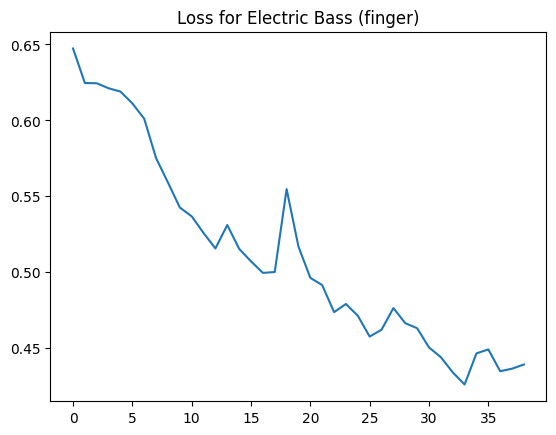

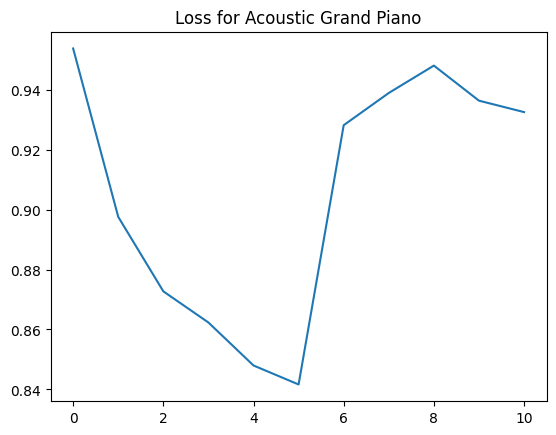

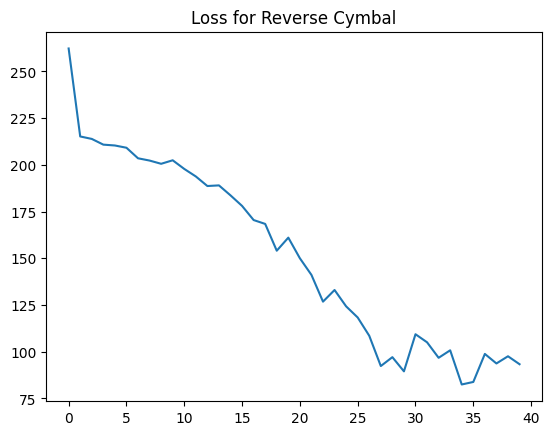

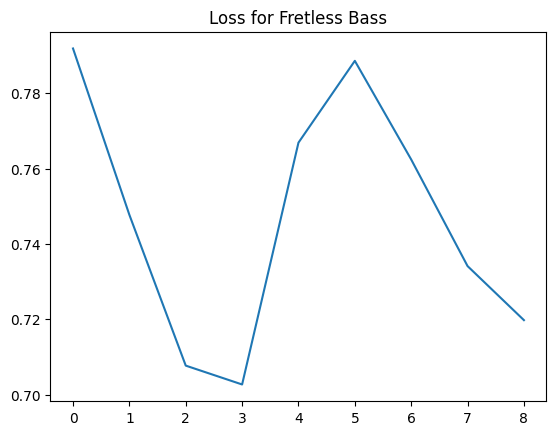

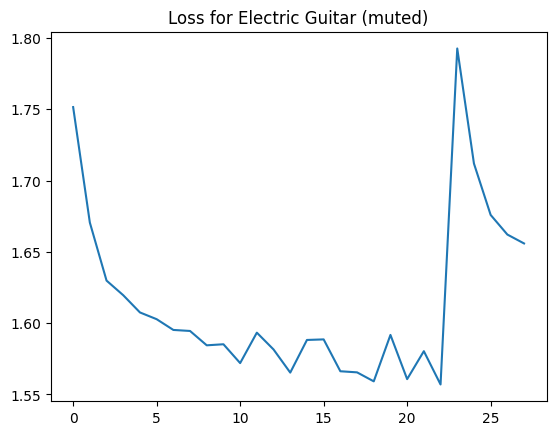

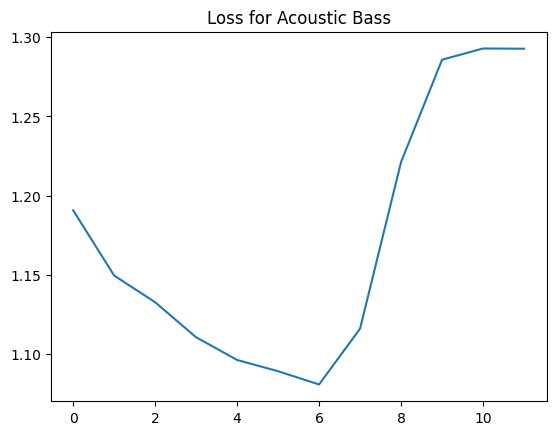

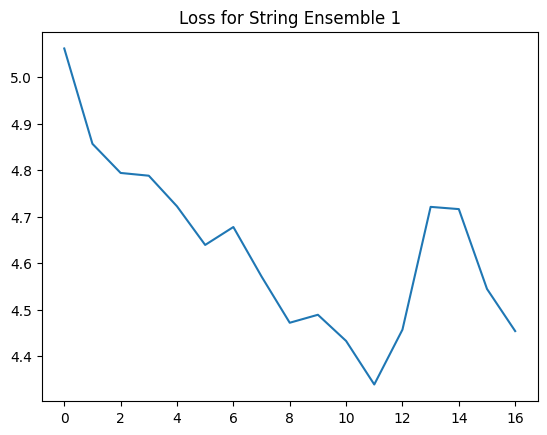

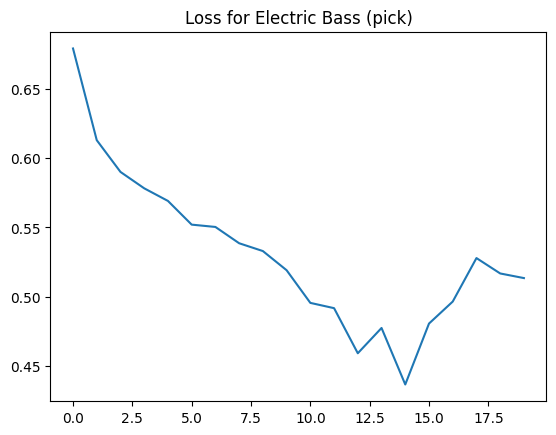

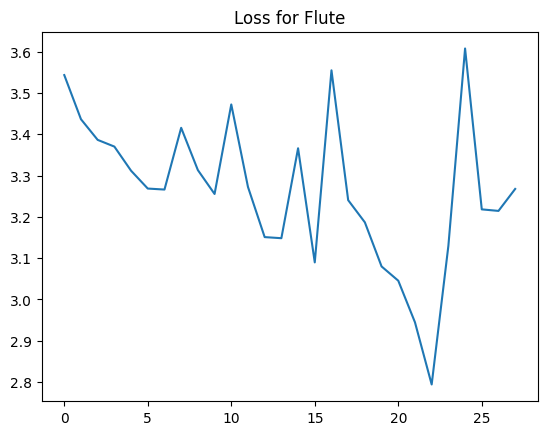

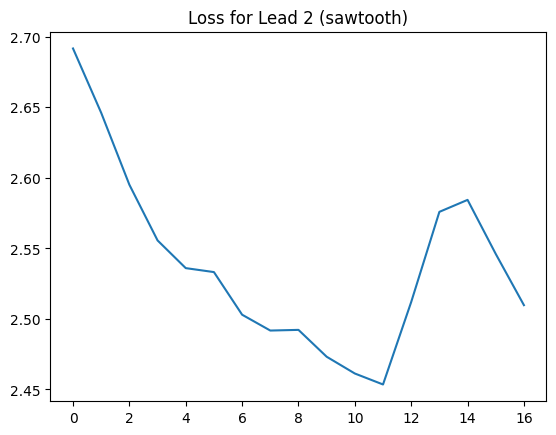

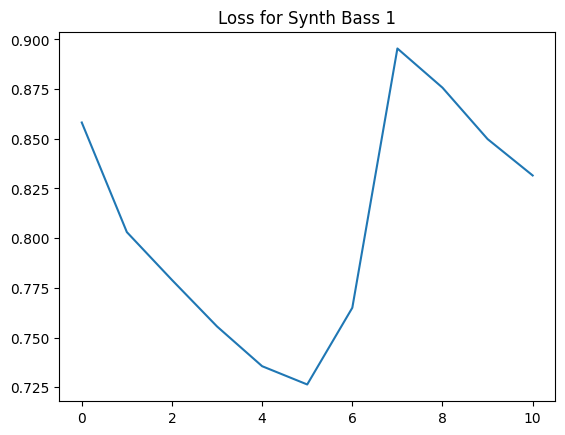

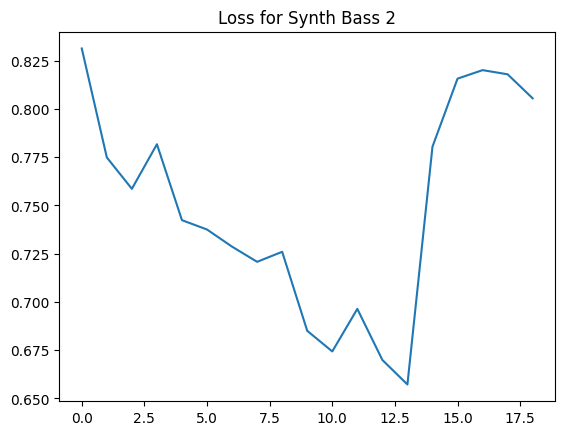

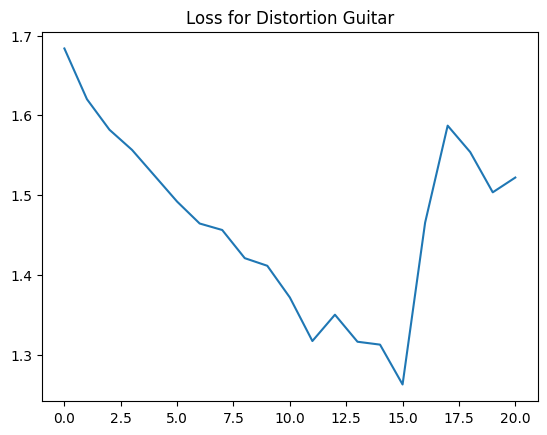

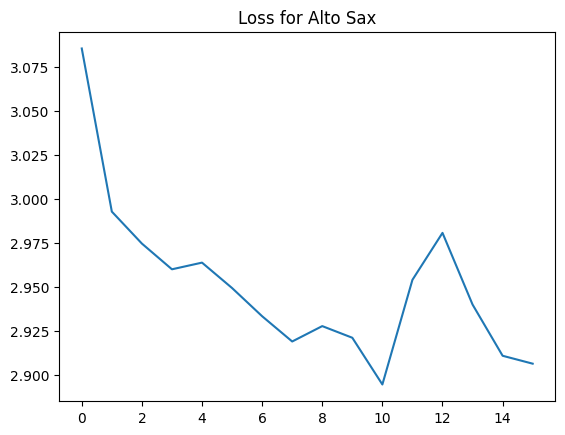

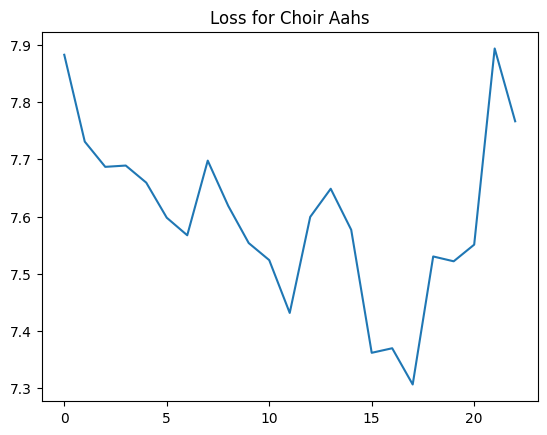

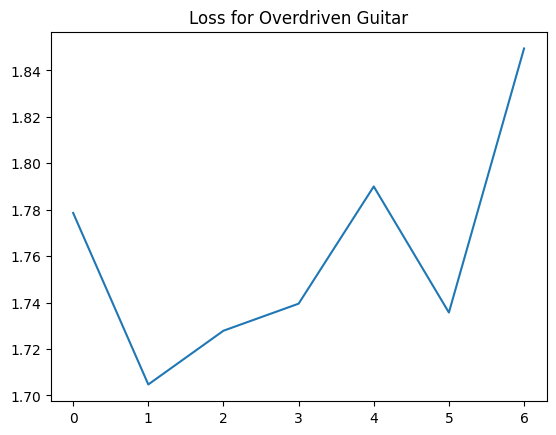

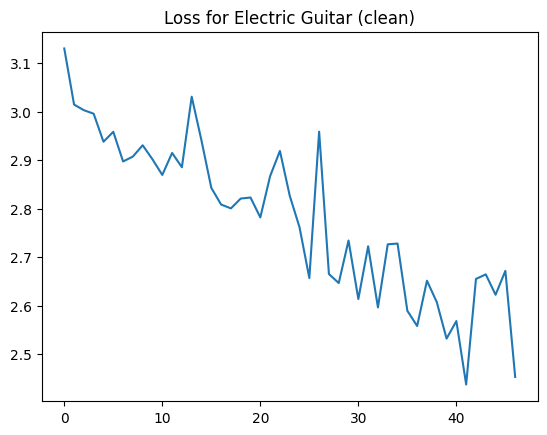

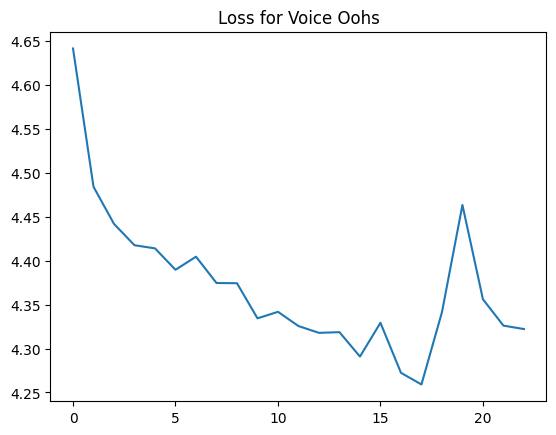

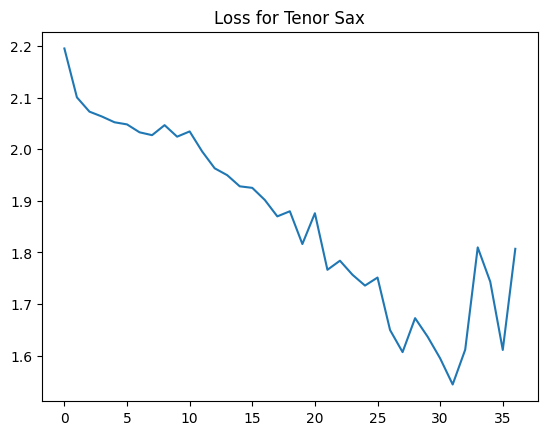

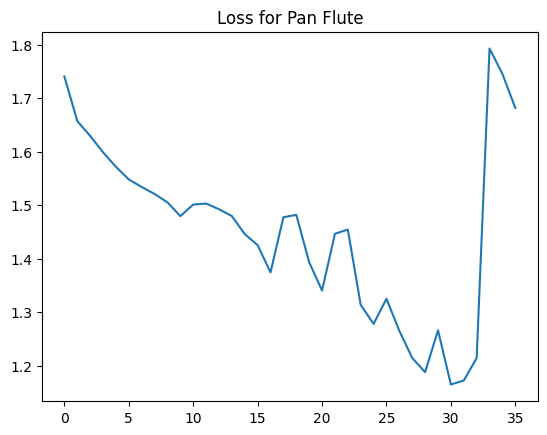

In [36]:
# for instru in top_instru.index:
for instru in m_top_instru.index:
    
    plt.plot(hist_data[instru].epoch, hist_data[instru].history['loss'], label='total loss')
    plt.title("Loss for " + instru)
    plt.show()

In [37]:
# 예측을 하려면 노트의 시퀀스를 넣어야함.
# 노트의 시퀀스를 만들어서 넣기.
# 노트 피치는 소프트맥스 함수로 나눠진거에서 샘플로 여러개를 가지고 오고 제일 높은 확률만 가져오지 않음

def predict_next_note(
    notes: np.ndarray, 
    keras_model: tf.keras.Model, 
    temperature: float = 1.0) -> int:
  # """Generates a note IDs using a trained sequence model."""

  assert temperature > 0 #온도가 노트들 랜덤생성하게 하는거 도와주는 펑션

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  # predictions = model.predict(inputs)
  predictions = keras_model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative.
  # if step < 0:
  #   step = step * -0.1
  # if duration < 0:
  #   duration = duration * -0.1
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [54]:
def get_generated_notes(
        notes: np.ndarray,
        keras_model: tf.keras.Model,
        temperature: float = 2.0,
        num_predictions: int = 300
):

    sample_notes = np.stack([notes[key] for key in key_order], axis=1)
    input_notes = (
        sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

    generated_notes = []
    prev_start = 0
    for _ in range(num_predictions):
        pitch, step, duration = predict_next_note(input_notes, keras_model, temperature)
        start = prev_start + step
        end = start + duration
        input_note = (pitch, step, duration)
        generated_notes.append((*input_note, start, end))
        input_notes = np.delete(input_notes, 0, axis=0)
        input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
        prev_start = start

    generated_notes = pd.DataFrame(
        generated_notes, columns=(*key_order, 'start', 'end'))
    
    return generated_notes

In [39]:
gen_notes_dict = {}
temperature = 3 #adjust temperature for the output sequence randomness
num_prediction = 300

for instrument_name, notes_df in random_notes.items():
    try:
        gen_note = get_generated_notes(notes_df, mod_data[instrument_name], temperature, num_prediction)
        gen_notes_dict[instrument_name] = gen_note
    except Exception as e:
        print(f"Error occurred while processing instrument: {instrument_name}: {e}")
        


1/1 [==============================] - 0s 14ms/step
Error occurred while processing instrument: Gunshot: 'Gunshot'
1/1 [==============================] - 0s 16ms/step
Error occurred while processing instrument: Oboe: 'Oboe'
1/1 [==============================] - 0s 14ms/step
Error occurred while processing instrument: Clarinet: 'Clarinet'
1/1 [==============================] - 0s 14ms/step
Error occurred while processing instrument: Electric Guitar (jazz): 'Electric Guitar (jazz)'
Error occurred while processing instrument: Violin: 'Violin'
Error occurred while processing instrument: Banjo: 'Banjo'
1/1 [==============================] - 0s 16ms/step
Error occurred while processing instrument: Trumpet: 'Trumpet'
Error occurred while processing instrument: Tubular Bells: 'Tubular Bells'
Error occurred while processing instrument: Electric Grand Piano: 'Electric Grand Piano'
Error occurred while processing instrument: Harpsichord: 'Harpsichord'
1/1 [==============================] - 0s 16

In [80]:
del gen_notes_dict['Flute']

In [73]:
instru = m_top_instru.index[8]
instru

'Lead 2 (sawtooth)'

In [147]:
# cont  : 8, 11, 12, 14, 16
# back? : 0, 1, 5,  7 , 18
# noisy : 3, 6, 17
# issue : 2, 4
try:
    instru = m_top_instru.index[14]
    out_file = 'MIDI/sample/out_mel10.mid'
    out_pm = notes_to_midi(
        gen_notes_dict[instru], out_file=out_file, instrument_name=instru)
    display_audio(out_pm)
except Exception as e:
    print(f"Error occurred while processing file {out_file}: {e}")

In [148]:
display_audio(out_pm)

In [132]:
x = [11, 0, 1, 5,]
comb = []
for instru_num in x:
    comb.append(m_top_instru.index[instru_num])
comb_dict = {}

for instru_name in comb:
    comb_dict[instru_name] = gen_notes_dict[instru_name]
comb_dict

{'Distortion Guitar':      pitch      step  duration      start        end
 0       71  0.167699  0.201926   0.167699   0.369624
 1       68  0.305813  0.111957   0.473512   0.585469
 2       62  0.161549  0.167323   0.635060   0.802384
 3       72  0.145382  0.166113   0.780442   0.946555
 4       71  0.143896  0.165265   0.924338   1.089603
 ..     ...       ...       ...        ...        ...
 295     77  0.142887  0.165818  42.643346  42.809164
 296     72  0.143706  0.165093  42.787052  42.952145
 297     70  0.143553  0.165229  42.930604  43.095834
 298     71  0.143467  0.165305  43.074072  43.239376
 299     71  0.143512  0.165265  43.217584  43.382849
 
 [300 rows x 5 columns],
 'Acoustic Grand Piano':      pitch      step  duration       start         end
 0       71  0.660859  0.174468    0.660859    0.835327
 1       71  0.511946  0.168937    1.172805    1.341742
 2       53  0.488388  0.190123    1.661193    1.851315
 3       42  0.439891  0.187558    2.101084    2.288642


In [133]:
try:
    out_file = 'MIDI/sample/mixture3.mid'
    out_pm_m = dict_to_midi(comb_dict, out_file)
    display_audio(out_pm_m)
except Exception as e:
    print(f"Error occurred while processing file {out_file}: {e}")

In [81]:
try:
    out_file = 'MIDI/sample/mixture2.mid'
    out_pm_m = dict_to_midi(gen_notes_dict, out_file)
    display_audio(out_pm_m)
except Exception as e:
    print(f"Error occurred while processing file {out_file}: {e}")

In [134]:
display_audio(out_pm_m)

In [43]:
# test_gen = get_generated_notes(raw_notes, test_mod, 2, 120)

In [44]:
test_gen

NameError: name 'test_gen' is not defined

In [ ]:
# generated_notes

In [ ]:
out_file = 'MIDI/sample/output6.mid'
out_pm = notes_to_midi(
    test_gen, out_file=out_file, instrument_name=instrument_name)
display_audio(out_pm)

In [ ]:
# 악곡은 노트의 연속성이니 시각화 해보기. 첫번쨰 instrument 가 피아노니까 트랙 길이에 음표, 피치, 시작 & 끝을 플롯해보기.
# count 는 input 에 있거나 없거나 상관없음. 
def plot_notes_roll(notes: pd.DataFrame, count: Optional[int] = None):
  if count:
    title = f'First {count} notes'
  else:
    title = f'Whole track'
    count = len(notes['pitch'])
  plt.figure(figsize=(20, 4))
  plot_pitch = np.stack([notes['pitch'], notes['pitch']], axis=0)
  plot_start_stop = np.stack([notes['start'], notes['end']], axis=0)
  plt.plot(
      plot_start_stop[:, :count], plot_pitch[:, :count], color="b", marker=".")
  plt.xlabel('Time [s]')
  plt.ylabel('Pitch')
  _ = plt.title(title)

In [ ]:
def plot_distributions(notes: pd.DataFrame, drop_percentile=2.5):
  plt.figure(figsize=[15, 5])
  plt.subplot(1, 3, 1)
  sns.histplot(notes, x="pitch", bins=20)

  plt.subplot(1, 3, 2)
  max_step = np.percentile(notes['step'], 100 - drop_percentile)
  sns.histplot(notes, x="step", bins=np.linspace(0, max_step, 21))

  plt.subplot(1, 3, 3)
  max_duration = np.percentile(notes['duration'], 100 - drop_percentile)
  sns.histplot(notes, x="duration", bins=np.linspace(0, max_duration, 21))

In [ ]:
gen_notes_dict[m_top_instru.index[0]]

dict_values([     pitch       step  duration         start           end
0       45  44.461758  1.303971     44.461758     45.765729
1       58  24.955128  1.412523     69.416885     70.829409
2       72  76.661850  2.240605    146.078735    148.319340
3       52  29.937323  1.185022    176.016058    177.201080
4       50  52.037464  1.630184    228.053522    229.683707
..     ...        ...       ...           ...           ...
295     75  30.656708  1.475449  10517.553486  10519.028935
296     65  20.095587  1.533730  10537.649073  10539.182803
297     75  28.921377  1.515806  10566.570450  10568.086256
298     64  20.681494  1.445457  10587.251944  10588.697401
299     82  29.636620  1.456571  10616.888564  10618.345135

[300 rows x 5 columns],      pitch      step  duration       start         end
0       39  0.183203  0.252675    0.183203    0.435879
1       38  2.096917  0.506531    2.280120    2.786652
2       52  2.279854  0.512953    4.559975    5.072928
3       45  2.294630  

In [ ]:
# plot_notes_roll(generated_notes)
plot_notes_roll(generated_notes)

NameError: name 'generated_notes' is not defined

In [ ]:
plot_distributions(generated_notes)